## The symmetric 4-city problem

solving the bottleneck travelling salesman problem using phase estimation.

### testing contraint:

 - 6 qubits for phase estimation.
 - 8 qubits initialized to the eigenvalue of the of the matrix $U$.
 - There are 3 hamilonian cycles, so we need eigenvalue and estimation qubits for each.
 - To solve the constraint problem we need a new operator $U$ satifying a max edge weight.

<div>
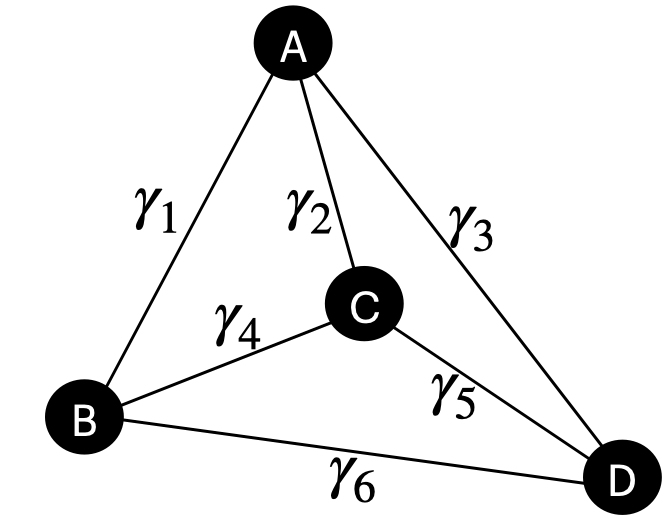
</div>

### we can assign arbitrary weights

$$\Large 1: A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_4}C \xrightarrow{\gamma_5}D\xrightarrow{\gamma_3}A: 4 + 4 + \mathbf{5} + 4 = 17$$

$$\Large 2: A\xrightarrow{\gamma_1}B \xrightarrow{\gamma_6}D \xrightarrow{\gamma_5}C\xrightarrow{\gamma_2}A: 4 + \mathbf{6} + 5 + 2 = 17$$

$$\Large 3: A\xrightarrow{\gamma_2}C \xrightarrow{\gamma_4}B \xrightarrow{\gamma_6}D\xrightarrow{\gamma_3}A: 2 + 4 + \mathbf{6} + 4 = 16$$

In [1]:
#### Debugging Tools:



eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']

# swap_operator = 1
# eig = eigstatelist[0]
# sim_types = ['statevector_simulator', 'aer_simulator']
# sim_type = sim_types[1]

# #### with the values above, getting zero on both simulator types.


# eigstate 0 seems like the correct solution#

n = 4 # estimation qubits
reverse = 0
swap_operator = 0
eig = eigstatelist[0]
if reverse:
    eig = eig[::-1]
sim_types = ['statevector_simulator', 'aer_simulator']
sim_type = sim_types[1] 



# reverse = 0
# swap_operator = 0
# eig = eigstatelist[0]

# if reverse:
#     eig = eig[::-1]

# sim_types = ['statevector_simulator', 'aer_simulator']
# sim_type = sim_types[1] 





In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math

gamma_1 = 4 # a <-> b
gamma_2 = 2 # a <-> c
gamma_3 = 4 # a <-> d
gamma_4 = 4 # b <-> c
gamma_5 = 5 # c <-> d
gamma_6 = 6 # b <-> d

weights = []

for i in range(1, 7):
    variable_name = "gamma_" + str(i)
    # Assuming you have variables like number_1, number_2, etc.
    current_number = locals()[variable_name]
    weights.append(current_number)

weights = np.array(weights)
print(weights)

[4 2 4 4 5 6]


we need to normalize the weights, $w$, so we only have values in $(0, 2\pi)$. We can do this by:

$$\Large w = \frac{w}{\mathrm{max}(w) + \epsilon} \times 2\pi$$

The addition of $\epsilon$ is included to avoid a max normalized weight of $2\pi$

**edit: normalizing by max does not work, we need to normalize by largest hamiltonian cycle, then multiply by $2\pi$**

we can just use the values we have above for now, but might be worth considering what strategy works best.
 - simplest solution would be to normalize based on the sum of all edge weights
 
 $$\Large w = \frac{w}{\mathrm{sum}(w)} \times 2\pi$$
 
 
 **edit2: multiplying it by $2\pi$ made it hard to verify where the solutions are, going to attempt again but multiply it by $\pi$**

we can just use the values we have above for now, but might be worth considering what strategy works best.
 - simplest solution would be to normalize based on the sum of all edge weights
 
 $$\Large w = \frac{w}{\mathrm{sum}(w)} \times \pi$$


In [3]:
eps = 1
#weights = weights / (max(weights) + eps) * 2 * np.pi

weights = weights / np.sum(weights)
#weights = weights / np.sum(weights) * np.pi

print('normalized weights: {}'.format(weights))

## solutions
print('solution 1: {}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[5] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[5] + weights[2]))

print('solutions after max weight removed')
print('solution 1: {}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0]  + weights[4] + weights[1]))
print('solution 3: {:.3f}'.format(weights[1] + weights[3] + weights[2]))

normalized weights: [0.16 0.08 0.16 0.16 0.2  0.24]
solution 1: 0.68
solution 2: 0.68
solution 3: 0.64
solutions after max weight removed
solution 1: 0.68
solution 2: 0.44
solution 3: 0.400


To construct $U$, we need to compute the tensor product of diagonal matrices $U_j$, where $ 1 \leq j \leq N$. $N$ denotes the number of cities in total.

$$\Large\left[U_j \right]_{kk} = \frac{1}{\sqrt{N}}e^{i\gamma_{jk}}$$


$$\Large U = \bigotimes_j^N U_j$$


for our contstraint test, we simply need a tensor product of 4 matrices:

$$\Large U = U_1 \otimes U_2 \otimes U_3 \otimes U_4$$

lets have a closer look at the matrix $U_1$
$$ \Large
\begin{bmatrix}
  1 & 0 & 0 & 0 \\
  0 & e^{i\gamma_{12}} & 0 & 0 \\
  0 & 0 & e^{i\gamma_{13}} & 0 \\
  0 & 0 & 0 & e^{i\gamma_{14}} \\
\end{bmatrix}
$$

constructing the large matrix U is straight forward. I am a little confused on how to construct a controlled-U operation such that we have the appropriate phase kickback. The 2018 paper does a decomposition, and claims that a $CU$ matrix can simply be achieved by the tensor product of the smaller $CU_J$ matrices. Need to confirm how this works.

A control gate can simply be constructed:

$$ \Large
\begin{bmatrix}
  \mathbb{1} & 0 \\
  0 & U \\
\end{bmatrix}
$$ 


#### January 16th clarification:

to construct a control gate, we need an equal amount of diagonal elements for the identity matrix above as we have in the diagonal of U, implying we double the size of U and store 1s in the first half of the diagonal 



#### January 31st clarification:

qiskit orders qubits backwards. This control gate needs to be reflected over the diagonal:

$$ \Large
\begin{bmatrix}
  U & 0 \\
  0 & \mathbb{1} \\
\end{bmatrix}
$$ 

In [4]:
# # https://github.com/qiskit-community/qiskit-textbook/blob/main/content/ch-algorithms/quantum-phase-estimation.ipynb
# # https://www.youtube.com/watch?v=zFgyMGklANM (how to create a custom gate)  

# # importing Qiskit
# from qiskit import IBMQ, Aer, transpile, assemble
# from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# from qiskit.circuit.library import QFT

# # for creating custom gates
# from qiskit import quantum_info as qi

# # import basic plot tools
# from qiskit.visualization import plot_histogram

In [5]:
# qiskit tools to establish circuit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# importing QFT
from qiskit.circuit.library import QFT

# for creating custom gates
from qiskit import quantum_info as qi

# import basic plot tools
from qiskit.visualization import plot_histogram

## creating CU matrix

In [6]:
### need the four values for each sub distance matrix:

m = 8 # eigenvalue qubits

U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[4] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(U) != 0))# confirming only the diagonal is being used.

if swap_operator:
    CUdiag = np.append(np.ones(2**m), np.diag(U))
else:
    CUdiag = np.append(np.diag(U), np.ones(2**m))


CU = qi.Operator(np.diag(CUdiag))
print(np.shape(CU))  ### needs to work on m + 1 qubits (2^(m+1) x 2^(m+1) matrix)


True
(512, 512)


## Confirming where the solutions are:



In [7]:
U_angles = np.around(np.diag(np.angle(U)), 4)

# solution 1: 2.1362830044410597
# solution 2: 2.1362830044410592
# solution 3: 2.0106192982974678

# U_angles = U_angles[U_angles > 2] ## range here is -pi to pi. Changing it to 0 to 2pi
# U_angles = U_angles[U_angles < 2.2]
# U_angles
print(np.where(U_angles==2.0106)) ### solution 3
print(np.where(U_angles == 2.1363)) ## solution 1 & 2


### according to May 2018 paper
eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']


eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
U_angles[eiglistint]

(array([  7,   8,  17,  20,  39,  40,  75,  87,  88, 107, 131, 144, 153,
       163, 203, 215, 216, 235]),)
(array([], dtype=int64),)


array([-2.0106, -2.0106, -2.0106, -2.2619, -2.2619, -2.5133])

In [8]:
# #manual multiplication for confirmation
# eigstate = np.zeros(256)
# eigstate[198] = 1   # where the solution is |111000110>
# eigstate = eigstate.reshape(-1,1) # changing to a column vector
# product = np.matmul(U,eigstate)
# print(np.where(np.angle(product) != 0)) ## confirming only same index has a nonzero value
# print(np.angle(product)[198])


# ### how would this work with CU

# CU_check = np.append(np.ones(2**m), np.diag(U))
# CU_check = np.diag(CU_check)

# eigstate = np.zeros(512)
# eigstate[454] = 1   # where the solution is |1>|111000110>
# eigstate = eigstate.reshape(-1,1) # changing to a column vector
# product = np.matmul(CU_check,eigstate)
# print(np.where(np.angle(product) != 0)) ## confirming only same index has a nonzero value
# print(np.angle(product)[454])

## Creating CU Prime matrix (removing max edge weight)

In [9]:
### need the four values for each sub distance matrix:

max_index = np.where(weights == np.max(weights))[0][0] ## largest weight in weights index
weights[max_index] = 0                                 ## setting the largest weight to zero

U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[4] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

Up = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(Up) != 0))# confirming only the diagonal is being used.

if swap_operator:
    CUdiag = np.append(np.ones(2**m), np.diag(Up))
else:
    CUdiag = np.append(np.diag(Up), np.ones(2**m))

# CUdiag = np.append(np.ones(2**m), np.diag(Up))
# #CUdiag = np.append(np.diag(Up), np.ones(2**m))

CUP = qi.Operator(np.diag(CUdiag))
print(np.shape(CUP))  ### needs to work on m + 1 qubits (2^(m+1) x 2^(m+1) matrix)
#CUP_check = UnitaryGate(np.diag(CUdiag), label='cupcheck')

True
(512, 512)


In [10]:
U_angles = np.around(np.diag(np.angle(Up)), 4)

# solution 1: 2.1362830044410597
# solution 2: 2.1362830044410592
# solution 3: 2.0106192982974678

# solutions after max weight removed
# solution 1: 2.1362830044410597
# solution 2: 1.3823007675795091
# solution 3: 1.2566370614359172


# U_angles = U_angles[U_angles > 2] ## range here is -pi to pi. Changing it to 0 to 2pi
# U_angles = U_angles[U_angles < 2.2]
# U_angles
print(np.where(U_angles==2.0106)) ### solution 3
print(np.where(U_angles == 2.1363)) ## solution 1 & 2

U_angles[eiglistint]

(array([  5,   7,   8,  20,  37,  39,  40,  73,  75,  85,  87,  88, 105,
       107, 129, 131, 144, 161, 163, 201, 203, 213, 215, 216, 233, 235]),)
(array([], dtype=int64),)


array([-2.0106, -2.0106,  2.7646, -2.2619,  2.5133, -2.5133])

In [11]:

qr = QuantumRegister(n, name = 'phase')
qr2 = QuantumRegister(m, name = 'eigenstate')
cr = ClassicalRegister(n, 'output')

qrp = QuantumRegister(n, name = 'phase two')
qr2p = QuantumRegister(m, name = 'eigstate two')
crp = ClassicalRegister(n, 'output two')

qc = QuantumCircuit(qr,qr2,cr,qrp,qr2p,crp)


# Apply H-Gates to counting qubits:
for qubit in range(2*n):
    if qubit < n:
        qc.h(qubit)
    else:
        qc.h(qubit + m)

# Prepare our eigenstate |psi>: state 198


# eigstatelist = ['11000110', '01101100', '10001101',
#                 '01110010', '11100001', '10110100']

# eig = eigstatelist[2]

for ind, val in enumerate(eig):
    if(int(val)):
        qc.x(ind + n)
        qc.x(ind + 2*n + m)


qc.draw()

┌───┐
       phase_0: ┤ H ├
                ├───┤
       phase_1: ┤ H ├
                ├───┤
       phase_2: ┤ H ├
                ├───┤
       phase_3: ┤ H ├
                ├───┤
  eigenstate_0: ┤ X ├
                ├───┤
  eigenstate_1: ┤ X ├
                └───┘
  eigenstate_2: ─────
                     
  eigenstate_3: ─────
                     
  eigenstate_4: ─────
                ┌───┐
  eigenstate_5: ┤ X ├
                ├───┤
  eigenstate_6: ┤ X ├
                └───┘
  eigenstate_7: ─────
                ┌───┐
   phase two_0: ┤ H ├
                ├───┤
   phase two_1: ┤ H ├
                ├───┤
   phase two_2: ┤ H ├
                ├───┤
   phase two_3: ┤ H ├
                ├───┤
eigstate two_0: ┤ X ├
                ├───┤
eigstate two_1: ┤ X ├
                └───┘
eigstate two_2: ─────
                     
eigstate two_3: ─────
                     
eigstate two_4: ─────
                ┌───┐
eigstate two_5: ┤ X ├
                ├───┤
eigstate two_6: ┤ X ├
                └───┘
eigstate two_7: ─────
                     
      output: 4/═════
                     
  output two: 4/═════

In [12]:
eig_qubits = np.arange(0,m) + n
eig_qubits2 = np.arange(0,m) + 2*n + m

repetitions = 1
for counting_qubit in range(n):
    applied_qubits = np.append([counting_qubit], [eig_qubits])
    applied_qubits2 = np.append([counting_qubit + m + n], [eig_qubits2])
    for i in range(repetitions):
        qc.unitary(CU, list(applied_qubits), label = "CU"); # This is CU
        qc.unitary(CUP, list(applied_qubits2), label = "CU'");
    repetitions *= 2
    
qc.append(QFT(num_qubits = n, inverse = True), qr)
qc.append(QFT(num_qubits = n, inverse = True), qrp)

qc.measure(qr,cr)
qc.measure(qrp,crp)

#qc.draw()

In [13]:
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

In [14]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [15]:
simulator = Aer.get_backend(sim_type)

In [16]:
qc = transpile(qc, simulator)  #### Doesnt like the inverse Quantum Fourier transform without decomposition
#qc.draw()

In [17]:
# Run and get counts
result = simulator.run(qc).result()
counts = result.get_counts(qc)
#plot_histogram(counts, title='check')

In [18]:
counts

{'1100 1110': 2,
 '1101 0110': 1,
 '1001 1101': 2,
 '1000 1101': 2,
 '0111 1101': 1,
 '0001 1101': 1,
 '1110 1100': 3,
 '0111 1011': 1,
 '1100 0111': 1,
 '1110 1011': 1,
 '1110 1111': 1,
 '1101 0011': 2,
 '1111 1101': 4,
 '1101 1101': 781,
 '1101 1100': 53,
 '1100 1101': 44,
 '0110 1101': 2,
 '0101 1100': 2,
 '1101 1001': 3,
 '1100 1100': 1,
 '0101 1101': 3,
 '1011 0000': 1,
 '1101 0001': 4,
 '1101 0010': 3,
 '1101 1011': 10,
 '0010 1101': 1,
 '0100 1101': 3,
 '1101 0100': 3,
 '1011 1011': 1,
 '0000 1101': 2,
 '1101 1110': 21,
 '1101 0101': 2,
 '1101 1010': 4,
 '0011 1101': 1,
 '1100 1011': 2,
 '1110 1101': 30,
 '1011 1101': 11,
 '1010 1101': 5,
 '1101 1111': 4,
 '1111 1110': 1,
 '1101 0000': 4}

In [19]:
max(counts, key=counts.get)

'1101 1101'

In [20]:
def bitstring_converter(string):
    
    values = []
    value = 0
    j = 0
    for i, v in enumerate(string):
        
        if v == '1':
            value += 1/(2**(i+1-j))
        elif v == " ":
            values.append(value)
            value = 0
            j = i+1
            
        if i == len(string)-1:
            values.append(value)
    
    return values

In [21]:
bitstring_converter(max(counts, key=counts.get))

[0.8125, 0.8125]

In [24]:
np.arange(0,1, 1/(2**(n)))

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375])

In [23]:
##### break phase estimation down to smaller block to understand CU possibly?
##### run a combination of all the parameters i've been tweaking and minimize error from exact solution?